# Using rapidfuzz to extract affiliatuons from JPE

First the JSON output file from tezseract is read in and made into a useable dataframe

In [61]:
#Importing the libraries
import json
import pandas as pd
from rapidfuzz import process
import requests

# Load input files from github
tesseract_input = requests.get('https://raw.githubusercontent.com/Matt970204/Affiliations_V2/main/1_Input%20files%20and%20processing%20input%20files/1_1_Input%20files/Tesseract%20affiliation%20output/JPE/JPE_affiliation_output_1940_2010.json')
json_data = tesseract_input.json()

# Import local JSON file
#f = open('/Users/MattJohnson/Desktop/Affiliations/1_Input files and processing input files/1_1_Input files/Tesseract affiliation output/JPE/JPE_affiliation_output_1940_2010.json')
#json_data = json.load(f)

# Define Journal and Dataframe
Journal_Name = 'JPE'
Reference_Data_List = []

# Extract Json Data into dataframe
for key1, value1 in json_data.items():
    Article_ID = key1
    content_type = value1["content_type"]
    author_list = value1["authors"]
    authorsNo = len(author_list)
    stable_url = value1["stable_url"]
    for key2 in value1["affiliations"]:
        Ref_type = key2
        if key2 == "found":
            ref_string = value1["affiliations"][key2]

    Reference_Data_List.append({'Journal_Name' : Journal_Name,
    'Authors_count' : authorsNo, 
    'Article_ID' : Article_ID, 'content_type' : content_type,
    'stable_url' : stable_url, 
    'Ref_type': Ref_type,  'ref_string':ref_string })

JPE_aff_ref_output_1940_2010 = pd.DataFrame.from_records(Reference_Data_List)     
JPE_aff_ref_output_1940_2010.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/Working files/JPE_aff_ref_output_1940_2010.xlsx')        

Next the Unique list of universities is read in, this is used as a database to check the affiliton string against using rapidfuzz. 

In [62]:
# Load in the list of unique Universites from github stored in 2_fuzzy matching
#affs = pd.read_excel("https://raw.githubusercontent.com/Matt970204/Affiliations_V2/main/2_Extracting%20affilitations/2_Fuzzy%20matching/University%20list/Unique%20Universities.xlsx")

# Local store
affs = pd.read_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/University list/Unique Universities.xlsx')
print(affs.shape)

#testdata = JPE_1940_2010.loc[0:20].reset_index(drop = True)
testdata = JPE_aff_ref_output_1940_2010

for i in range(len(affs)):
    #Replaceing title case and stripping leading space
    affs.iat[i,0] = affs.iat[i,0].strip().title()
Affiliation_choices = affs['Affilliation'].values.tolist()

for i in range(len(testdata)):
    #Replaceing title case and stripping leading space
    testdata.iat[i,6] = testdata.iat[i,6].strip().title()


(849, 14)


In [63]:
x = process.extract(" Johannes Hórner Yale University Andrzej Skrzypacz Stanford University" ,Affiliation_choices, limit= 10, score_cutoff= 90)
print(x[0][2])
print(Affiliation_choices[x[0][2]])
print(Affiliation_choices[x[1][2]])

0
Yale University
Stanford University


Next the test data is split line by line and parsed through the fuzzy matching library rapid fuzz.  Using the process.extract function a list of variables from a data frame being the unique universities is checked to see if there is a match in the input line from tesseract.

In [64]:
# For loop to iterate through lines in the input data and check to see if this exists in the created data base. 
# If it exists it is appended to a dataframe as the next affiliton for that paper
for i in range(len(testdata)):
    split = testdata.iat[i,6].split('\n\n')
    split_len = len(testdata.iat[i,6].split('\n\n'))
    affiliations = []
    count_no_aff = 0
    for j in range(split_len):
        #print(i)
        if len(process.extract(split[j],Affiliation_choices, limit= 10, score_cutoff= 90)) > 0:
            affiliations = affiliations + process.extract(split[j],Affiliation_choices, limit= 10, score_cutoff= 90)
        if len(process.extract(split[j],Affiliation_choices, limit= 10, score_cutoff= 90)) == 0:
            count_no_aff = count_no_aff+1

        if count_no_aff == 8:
            break
        if j == split_len:
            break
    
    print(affiliations)
    print("Length = " , len(affiliations), ", Number = ",i)
    if len(affiliations) == 0:
        testdata.loc[i,['Missing aff']] = "Missing"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 1:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 2:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 3:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 4:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 5:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
        print(affiliations)
    elif len(affiliations) == 6:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 7:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 8:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 9:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 10:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['aff10']] = affiliations[9][0]
        testdata.loc[i,['aff10_Picked_Up']] = Affiliation_choices[affiliations[9][2]]
        testdata.loc[i,['aff10_Score']] = affiliations[9][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 11:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['aff10']] = affiliations[9][0]
        testdata.loc[i,['aff10_Picked_Up']] = Affiliation_choices[affiliations[9][2]]
        testdata.loc[i,['aff10_Score']] = affiliations[9][1]
        testdata.loc[i,['aff11']] = affiliations[10][0]
        testdata.loc[i,['aff11_Picked_Up']] = Affiliation_choices[affiliations[10][2]]
        testdata.loc[i,['aff11_Score']] = affiliations[10][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 12:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['aff10']] = affiliations[9][0]
        testdata.loc[i,['aff10_Picked_Up']] = Affiliation_choices[affiliations[9][2]]
        testdata.loc[i,['aff10_Score']] = affiliations[9][1]
        testdata.loc[i,['aff11']] = affiliations[10][0]
        testdata.loc[i,['aff11_Picked_Up']] = Affiliation_choices[affiliations[10][2]]
        testdata.loc[i,['aff11_Score']] = affiliations[10][1]
        testdata.loc[i,['aff12']] = affiliations[11][0]
        testdata.loc[i,['aff12_Picked_Up']] = Affiliation_choices[affiliations[11][2]]
        testdata.loc[i,['aff12_Score']] = affiliations[11][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    else: 
        testdata.loc[i,['Missing aff']] = "More than 12"


[('Yale University', 100.0, 0), ('Stanford University', 100.0, 8)]
Length =  2 , Number =  0
[('National Bureau Of Economic Research', 90.0, 531), ('Harvard University', 90.0, 695), ('University Of Minnesota', 90.0, 289), ('National Bureau Of Economic Research', 90.0, 531)]
Length =  4 , Number =  1
[('Purdue University', 100.0, 83), ('Purdue University', 100.0, 83)]
Length =  2 , Number =  2
[('Tilburg University', 100.0, 115), ('University Of Mannheim', 100.0, 259), ('University Of Mannheim', 90.0, 259)]
Length =  3 , Number =  3
[('University Of Maryland', 90.0, 772)]
Length =  1 , Number =  4
[('Columbia University', 100.0, 6), ('New York University', 90.0, 145), ('York University', 90.0, 829), ('University Of Pennsylvania', 100.0, 364)]
Length =  4 , Number =  5
[('National Bureau Of Economic Research', 90.0, 531), ('Harvard University', 90.0, 695), ('Coursera', 100.0, 7)]
Length =  3 , Number =  6
[]
Length =  0 , Number =  7
[('Microsoft Research', 90.0, 105), ('University Of Pe

In [65]:
testdata.loc[1,['aff1']]

aff1    National Bureau Of Economic Research
Name: 1, dtype: object

In [66]:
list(testdata.columns.values)
testdata = testdata[['Journal_Name',
 'Authors_count',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff9',
 'aff10',
 'aff11',
 'aff12',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8_Picked_Up',
 'aff8_Score',
 'aff9_Picked_Up',
 'aff9_Score',
 'aff10_Picked_Up',
 'aff10_Score',
 'aff11_Picked_Up',
 'aff11_Score',
 'aff12_Picked_Up',
 'aff12_Score']]
list(testdata.columns.values)

['Journal_Name',
 'Authors_count',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff9',
 'aff10',
 'aff11',
 'aff12',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8_Picked_Up',
 'aff8_Score',
 'aff9_Picked_Up',
 'aff9_Score',
 'aff10_Picked_Up',
 'aff10_Score',
 'aff11_Picked_Up',
 'aff11_Score',
 'aff12_Picked_Up',
 'aff12_Score']

In [67]:
print(testdata.iat[1,9])
print(testdata.iat[1,20])

# Excel output to get an overview of the data
testdata.head
testdata.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/JPE/Test files/JPE_aff_ref_output_1940_2010_affs_out testing.xlsx') 

National Bureau Of Economic Research
nan


In [68]:
import numpy as np
testdata = testdata.replace(np.nan, '', regex=True)
for i in range(len(testdata)):
    for j in range(9,20):
    #Replaceing title case and stripping leading space
        testdata.iat[i,j] = testdata.iat[i,j].strip().title()
        testdata.iat[i,j] = testdata.iat[i,j].rstrip(',')

# Columbia
# Columbia University
        if testdata.iat[i,j] == 'Columbia':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Columbia", "Columbia University")

        if testdata.iat[i,j] == 'Columbia Business School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Columbia Business School", "Columbia University")

        if testdata.iat[i,j] == 'Columbia Graduate School Of Business':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Columbia Graduate School Of Business", "Columbia University")
    
# Harvard
#Harvard University
        if testdata.iat[i,j] == 'Harvard':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Business School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Business School", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Graduate School of Design':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Graduate School of Design", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Law School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Law School", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Divinity School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Divinity School", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Medical School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Medical School", "Harvard University")

        if testdata.iat[i,j] == 'John F. Kennedy School of Government':
            testdata.iat[i,j] = testdata.iat[i,j].replace("John F. Kennedy School of Government", "Harvard University")

        if testdata.iat[i,j] == 'Harvard T.H. Chan School of Public Health':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Harvard T.H. Chan School of Public Health', "Harvard University")

        if testdata.iat[i,j] == 'Harvard John A. Paulson School of Engineering and Applied Sciences':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard John A. Paulson School of Engineering and Applied Sciences", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Kenneth C. Griffin Graduate School of Arts and Sciences':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Kenneth C. Griffin Graduate School of Arts and Sciences", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Division of Continuing Education':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Division of Continuing Education", "Harvard University")



# Oxford
# Base Oxford spelling
# University Of Oxford
        if testdata.iat[i,j] == 'Oxford':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Oxford", "University Of Oxford")

        if testdata.iat[i,j] == 'Oxford University':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Oxford University', "University Of Oxford")

        if testdata.iat[i,j] == 'Christ Church':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Christ Church', "University Of Oxford")

        if testdata.iat[i,j] == 'Nuffield College, Oxford':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Nuffield College', "University Of Oxford")

        if testdata.iat[i,j] == 'Trinity College, Oxford':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Trinity College', "University Of Oxford")   
        
        if testdata.iat[i,j] == 'All Souls College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("All Souls College", "University Of Oxford")   

        if testdata.iat[i,j] == 'Balliol College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Balliol College", "University Of Oxford")

        if testdata.iat[i,j] == 'Brasenose College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Brasenose College", "University Of Oxford")

        if testdata.iat[i,j] == 'Corpus Christi College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Corpus Christi College", "University Of Oxford")

        if testdata.iat[i,j] == 'Exeter College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Exeter College", "University Of Oxford")

        if testdata.iat[i,j] == 'Green Templeton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Green Templeton College", "University Of Oxford")

        if testdata.iat[i,j] == 'Harris Manchester College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harris Manchester College", "University Of Oxford")

        if testdata.iat[i,j] == 'Hertford College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Hertford College", "University Of Oxford")

        if testdata.iat[i,j] == 'Jesus College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Jesus College", "University Of Oxford")

        if testdata.iat[i,j] == 'Keble College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Keble College", "University Of Oxford")

        if testdata.iat[i,j] == 'Kellogg College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Kellogg College", "University Of Oxford")

        if testdata.iat[i,j] == 'Lady Margaret Hall':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Lady Margaret Hall", "University Of Oxford")

        if testdata.iat[i,j] == 'Linacre College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Linacre College", "University Of Oxford")

        if testdata.iat[i,j] == 'Lincoln College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Lincoln College", "University Of Oxford")

        if testdata.iat[i,j] == 'Magdalen College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Magdalen College", "University Of Oxford")

        if testdata.iat[i,j] == 'Mansfield College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Mansfield College", "University Of Oxford")

        if testdata.iat[i,j] == 'Merton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Merton College", "University Of Oxford")

        if testdata.iat[i,j] == 'New College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("New College", "University Of Oxford")

        if testdata.iat[i,j] == 'Oriel College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Oriel College", "University Of Oxford")

        if testdata.iat[i,j] == 'Pembroke College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pembroke College", "University Of Oxford")

        if testdata.iat[i,j] == 'Reuben College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Reuben College", "University Of Oxford")

        if testdata.iat[i,j] == 'Somerville College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Somerville College", "University Of Oxford")

        if testdata.iat[i,j] == "St Anne's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Anne's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Antony's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Antony's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Catherine's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Catherine's College", "University Of Oxford")

        if testdata.iat[i,j] == 'St Cross College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Cross College", "University Of Oxford")

        if testdata.iat[i,j] == 'St Edmund Hall':
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Edmund Hall", "University Of Oxford")

        if testdata.iat[i,j] == "St Hilda's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Hilda's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Hugh's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Hugh's College", "University Of Oxford")

        if testdata.iat[i,j] == "St John's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St John's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Peter's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Peter's College", "University Of Oxford")  

        if testdata.iat[i,j] == "The Queen's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("The Queen's College", "University Of Oxford")  

        if testdata.iat[i,j] == 'University College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("University College", "University Of Oxford")  

        if testdata.iat[i,j] == 'Wadham College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Wadham College", "University Of Oxford")  

        if testdata.iat[i,j] == 'Wolfson College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Wolfson College", "University Of Oxford")  

        if testdata.iat[i,j] == 'Worcester College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Worcester College", "University Of Oxford")  

# Yale
# Base Yale spelling
# Yale University
        if testdata.iat[i,j] == 'Yale':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Yale", "Yale University")

        if testdata.iat[i,j] == 'Berkeley College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Berkeley College", "Yale University")

        if testdata.iat[i,j] == 'Branford College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Branford College", "Yale University")

        if testdata.iat[i,j] == 'Davenport College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Davenport College", "Yale University")

        if testdata.iat[i,j] == 'Ezra Stiles College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Ezra Stiles College", "Yale University")

        if testdata.iat[i,j] == 'Jonathan Edwards College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Jonathan Edwards College", "Yale University")

        if testdata.iat[i,j] == 'Benjamin Franklin College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Benjamin Franklin College", "Yale University")

        if testdata.iat[i,j] == 'Grace Hopper College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Grace Hopper College", "Yale University")

        if testdata.iat[i,j] == 'Morse College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Morse College", "Yale University")

        if testdata.iat[i,j] == 'Pauli Murray College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pauli Murray College", "Yale University")

        if testdata.iat[i,j] == 'Pierson College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pierson College", "Yale University")

        if testdata.iat[i,j] == 'Saybrook College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Saybrook College", "Yale University")

        if testdata.iat[i,j] == 'Silliman College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Silliman College", "Yale University")

        if testdata.iat[i,j] == 'Timothy Dwight College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Timothy Dwight College", "Yale University")

        if testdata.iat[i,j] == 'Trumbull College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Trumbull College", "Yale University")

# Cambridge
# Base Cambridge spelling
# University of Cambridge
        if testdata.iat[i,j] == 'Cambridge':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Cambridge", "University of Cambridge")

        if testdata.iat[i,j] == "Christ's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Christ's College", "University of Cambridge")

        if testdata.iat[i,j] == 'Churchill College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Churchill College", "University of Cambridge")

        if testdata.iat[i,j] == 'Clare College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Clare College", "University of Cambridge")

        if testdata.iat[i,j] == 'Clare Hall':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Clare Hall", "University of Cambridge")

        if testdata.iat[i,j] == 'Corpus Christi College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Corpus Christi College", "University of Cambridge")

        if testdata.iat[i,j] == 'Darwin College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Darwin College", "University of Cambridge")

        if testdata.iat[i,j] == 'Downing College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Downing College", "University of Cambridge")

        if testdata.iat[i,j] == 'Emmanuel College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Emmanuel College", "University of Cambridge")

        if testdata.iat[i,j] == 'Fitzwilliam College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Fitzwilliam College", "University of Cambridge")

        if testdata.iat[i,j] == 'Girton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Girton College", "University of Cambridge")

        if testdata.iat[i,j] == 'Gonville & Caius College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Gonville & Caius College", "University of Cambridge")

        if testdata.iat[i,j] == 'Homerton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Homerton College", "University of Cambridge")

        if testdata.iat[i,j] == 'Jesus College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Jesus College", "University of Cambridge")

        if testdata.iat[i,j] == "King's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("King's College", "University of Cambridge")

        if testdata.iat[i,j] == 'Lucy Cavendish College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Lucy Cavendish College", "University of Cambridge")

        if testdata.iat[i,j] == 'Magdalene College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Magdalene College", "University of Cambridge")

        if testdata.iat[i,j] == 'Murray Edwards College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Murray Edwards College", "University of Cambridge")

        if testdata.iat[i,j] == 'Newnham College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Newnham College", "University of Cambridge")

        if testdata.iat[i,j] == 'Pembroke College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pembroke College", "University of Cambridge")

        if testdata.iat[i,j] == 'Peterhouse':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Peterhouse", "University of Cambridge")
        
        if testdata.iat[i,j] == "Queens' College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Queens' College", "University of Cambridge")

        if testdata.iat[i,j] == 'Robinson College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Robinson College", "University of Cambridge")

        if testdata.iat[i,j] == 'Selwyn College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Selwyn College", "University of Cambridge")

        if testdata.iat[i,j] == 'Sidney Sussex College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Sidney Sussex College", "University of Cambridge")

        if testdata.iat[i,j] == "St Catharine's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Catharine's College", "University of Cambridge")

        if testdata.iat[i,j] == "St Edmund's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Edmund's College", "University of Cambridge")

        if testdata.iat[i,j] == 'Trinity College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Trinity College", "University of Cambridge")

        if testdata.iat[i,j] == "St John's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St John's College", "University of Cambridge")

        if testdata.iat[i,j] == "Trinity Hall":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Trinity Hall", "University of Cambridge")

        if testdata.iat[i,j] == "St Edmund's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Edmund's College", "University of Cambridge")

        if testdata.iat[i,j] == "Wolfson College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Wolfson College", "University of Cambridge")

# Texas A&M University
        if testdata.iat[i,j] == 'Texas A And M University':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Texas A And M University", "Texas A&M University")

        if testdata.iat[i,j] == 'Texas A & M University':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Texas A & M University", "Texas A&M University")

        if testdata.iat[i,j] == 'Texas A. And M. University':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Texas A. And M. University", "Texas A&M University")


    

In [69]:
# Removing duplicate entries of the same university

import numpy as np
testdata = testdata.replace(np.nan, '', regex=True)

#Range for affiliations in JPE
for i in range(len(testdata)):
    for j in range(9,19):
    #If 1 = 2, or 2 = 3
        if testdata.iat[i,j] == testdata.iat[i,j+1]:
            testdata.iat[i,j+1] = np.nan

    #If 1 = 3, 2 = 4, 3 = 5
    for j in range(9,18):
    #Replaceing title case and stripping leading space
        if testdata.iat[i,j] == testdata.iat[i,j+2]:
            testdata.iat[i,j+2] = np.nan

    #If 1 = 4, 2 = 5, 3 = 6
    for j in range(9,17):
    #Replaceing title case and stripping leading space
        if testdata.iat[i,j] == testdata.iat[i,j+3]:
            testdata.iat[i,j+3] = np.nan

testdata = testdata.replace('', np.nan, regex=True)

In [70]:
list(testdata.columns.values)
testdata_manipulated = testdata[['Journal_Name',
 'Authors_count',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff9',
 'aff10',
 'aff11',
 'aff12',
  'aff1',
  'aff1_Picked_Up',
 'aff1_Score',
  'aff2',
 'aff2_Picked_Up',
 'aff2_Score',
  'aff3',
 'aff3_Picked_Up',
 'aff3_Score',
  'aff4',
 'aff4_Picked_Up',
 'aff4_Score',
  'aff5',
 'aff5_Picked_Up',
 'aff5_Score',
  'aff6',
 'aff6_Picked_Up',
 'aff6_Score',
  'aff7',
 'aff7_Picked_Up',
 'aff7_Score',
  'aff8',
 'aff8_Picked_Up',
 'aff8_Score',
  'aff9',
 'aff9_Picked_Up',
 'aff9_Score',
  'aff10',
 'aff10_Picked_Up',
 'aff10_Score',
  'aff11',
 'aff11_Picked_Up',
 'aff11_Score',
  'aff12',
 'aff12_Picked_Up',
 'aff12_Score']]
list(testdata_manipulated.columns.values)

['Journal_Name',
 'Authors_count',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff9',
 'aff10',
 'aff11',
 'aff12',
 'aff1',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8',
 'aff8_Picked_Up',
 'aff8_Score',
 'aff9',
 'aff9_Picked_Up',
 'aff9_Score',
 'aff10',
 'aff10_Picked_Up',
 'aff10_Score',
 'aff11',
 'aff11_Picked_Up',
 'aff11_Score',
 'aff12',
 'aff12_Picked_Up',
 'aff12_Score']

In [71]:
# Excel output to get an overview of the data
testdata_manipulated.head
testdata_manipulated.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/JPE/Test files/JPE_aff_ref_output_1940_2010_affs_out.xlsx') 

In [72]:
# This is taking a dataframe with multiple affilitaion columns and melting these to be all one column.
melted = testdata_manipulated.melt(id_vars= 'Article_ID', value_vars=['aff1','aff2','aff3','aff4','aff5','aff6','aff7','aff8','aff9','aff10']).dropna()
melted.rename(columns = {'variable':'Aff number'}, inplace = True)
melted.rename(columns = {'value':'Affiliation'}, inplace = True)
print(melted.head())

  Article_ID Aff number                           Affiliation
0   26549911       aff1                       Yale University
1   26549912       aff1  National Bureau Of Economic Research
2   26549913       aff1                     Purdue University
3   26549914       aff1                    Tilburg University
4   26549915       aff1                University Of Maryland


In [73]:
#Reading in the master file and correctly formatting the article ID to match back onto the meltef file

#Load in master from Github
JPE_master = pd.read_excel("https://raw.githubusercontent.com/Matt970204/Affiliations_V2/main/1_Input%20files%20and%20processing%20input%20files/1_1_Input%20files/Master%20lists/Processed/JPE_processed.xlsx")

# Local master file
#JPE_master = pd.read_excel('/Users/MattJohnson/Desktop/Affiliations/1_Input files and processing input files/1_1_Input files/Master lists/Processed/JPE_processed.xlsx')

for i in range(len(JPE_master)):
    JPE_master.loc[i,['Article_ID']] = JPE_master.loc[i,['stable_url']].to_string().rsplit('/',1)[-1]

JPE_master_condenced  = JPE_master[['Article_ID','year']]
JPE_master_condenced.head()

,Article_ID,year
0,26549909,2016.0
1,26549910,2016.0
2,26549911,2016.0
3,26549912,2016.0
4,26549913,2016.0


In [74]:
# Merging the masterfile onto the new melted file to get additional data
JPE_melted_master = melted.merge(JPE_master_condenced, how = 'left', on = 'Article_ID')
JPE_melted_master = JPE_melted_master.sort_values(by=['year'])
JPE_melted_master.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/JPE/JPE_melted_master.xlsx') 
JPE_melted_master.head()

,Article_ID,Aff number,Affiliation,year
3848,1824212,aff1,Harvard University,1940.0
7741,1825595,aff1,Duke University,1940.0
7742,1825598,aff1,University Of Chicago,1940.0
7743,1824376,aff1,Duke University,1940.0
7744,1824379,aff1,University Of Arkansas,1940.0


In [75]:
# Counting the number of times a certain affiliton occurs
JPE_melted_master['aff_cum_counts'] = JPE_melted_master.groupby(['Affiliation']).cumcount()+1
JPE_melted_master.head()
JPE_melted_master.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/JPE/Test files/JPE_melted_master_aff_count.xlsx') 

In [76]:
# Storing the master file to transer between notebooks
%store JPE_melted_master

Stored 'JPE_melted_master' (DataFrame)


In [77]:
# Checking the top 20 occurances of Universities over the 70 years
highest_vals = JPE_melted_master.drop_duplicates(subset = ['Affiliation'], keep = 'last')
highest_vals_10 = highest_vals.nlargest(20,'aff_cum_counts')
highest_vals_10

,Article_ID,Aff number,Affiliation,year,aff_cum_counts
13392,26549859,aff7,University Of Chicago,2016.0,892
12306,26549884,aff4,National Bureau Of Economic Research,2016.0,858
12307,26549870,aff4,Harvard University,2016.0,444
11685,26549870,aff3,Massachusetts Institute Of Technology,2016.0,388
11691,26549861,aff3,Stanford University,2016.0,314
9143,1828594,aff2,Icrea-Barcelona Institute Of Political Economy,1967.0,288
11043,26549900,aff3,Columbia University,2016.0,274
12302,26549916,aff4,University Of Pennsylvania,2016.0,266
0,26549911,aff1,Yale University,2016.0,252
11678,26549890,aff3,Princeton University,2016.0,242


     Article_ID Aff number             Affiliation    year  aff_cum_counts
3848    1824212       aff1      Harvard University  1940.0               1
7741    1825595       aff1         Duke University  1940.0               1
7742    1825598       aff1   University Of Chicago  1940.0               1
7743    1824376       aff1         Duke University  1940.0               2
7744    1824379       aff1  University Of Arkansas  1940.0               1


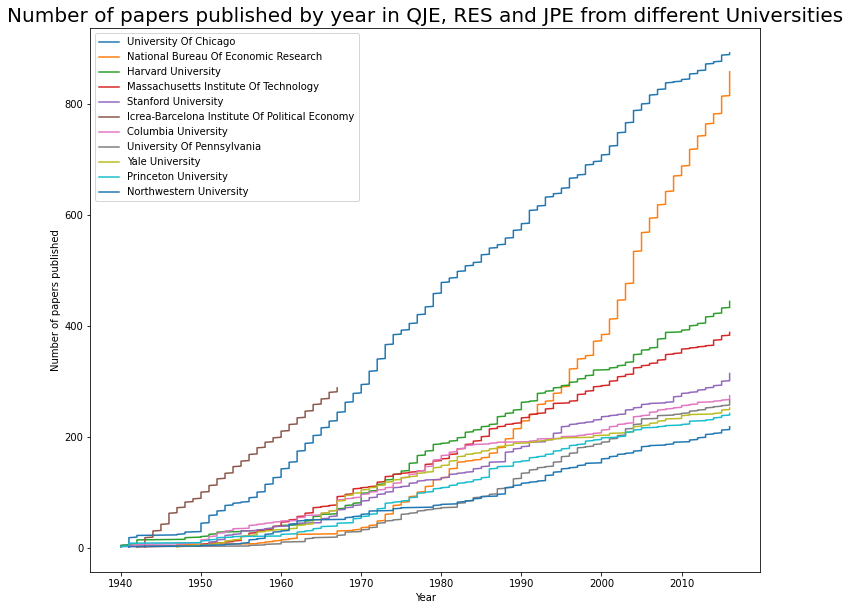

In [78]:
#Stacked plot on all years
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Combined_cumcount = JPE_melted_master
print(Combined_cumcount.head())

a = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[0,2])]
b = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[1,2])]
c = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[2,2])]
d = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[3,2])]
e = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[4,2])]
f = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[5,2])]
g = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[6,2])]
h = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[7,2])]
i = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[8,2])]
j = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[9,2])]
k = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[10,2])]

plt.figure(figsize=(12,10))
plt.plot(a['year'],a['aff_cum_counts'], label = highest_vals_10.iat[0,2])
plt.plot(b['year'],b['aff_cum_counts'], label = highest_vals_10.iat[1,2])
plt.plot(c['year'],c['aff_cum_counts'], label = highest_vals_10.iat[2,2])
plt.plot(d['year'],d['aff_cum_counts'], label = highest_vals_10.iat[3,2])
plt.plot(e['year'],e['aff_cum_counts'], label = highest_vals_10.iat[4,2])
plt.plot(f['year'],f['aff_cum_counts'], label = highest_vals_10.iat[5,2])
plt.plot(g['year'],g['aff_cum_counts'], label = highest_vals_10.iat[6,2])
plt.plot(h['year'],h['aff_cum_counts'], label = highest_vals_10.iat[7,2])
plt.plot(i['year'],i['aff_cum_counts'], label = highest_vals_10.iat[8,2])
plt.plot(j['year'],j['aff_cum_counts'], label = highest_vals_10.iat[9,2])
plt.plot(k['year'],k['aff_cum_counts'], label = highest_vals_10.iat[10,2])

plt.title('Number of papers published by year in QJE, RES and JPE from different Universities', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Number of papers published')

plt.legend()
plt.show()